In [76]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle as pkl

from sklearn.metrics import roc_auc_score

import seaborn as sb
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [21]:
path_data='/om2/user/khrovati/data/cross_system_integration/'
path_fig=path_data+'figures/'
path_names=path_data+'names_parsed/'

In [69]:
# Load distances 
dataset_map=pkl.load(open(path_names+'datasets.pkl','rb'))
system_map=pkl.load(open(path_names+'systems.pkl','rb'))

In [14]:
dataset_metric_fns={
    'pancreas_conditions_MIA_HPAP2':'combined_orthologuesHVG',
    'retina_adult_organoid':'combined_HVG',
    'adipose_sc_sn_updated':'adiposeHsSAT_sc_sn',
}

In [19]:
distances={
    dataset:pkl.load(open(path_data+dataset+'/'+fn+'_PcaSysBatchDist.pkl','rb'))
    for dataset, fn in dataset_metric_fns.items()}

## Plot one ct in all sample pair groups (delta cells of pancreas)
>>>>>>> 8f39c11 (dataset summaries)

In [8]:
# Prepare df for plotting (focus on delta cells)
plot=[]
ct='delta'
dat=distances['pancreas_conditions_MIA_HPAP2'][ct]
y_col='Compared samples'
for comparison,dist in dat.items():
    dist=pd.DataFrame(dist,columns=['dist'])
    dist['group']=ct
    dist[y_col]=comparison
    plot.append(dist)
plot=pd.concat(plot)

In [9]:
# Make data names prettier
plot.rename({'dist':'Distance'},axis=1,inplace=True)
plot.replace({'s0_within':'Mouse\n(within datasets)',
              's0_between':'Mouse\n(between datasets)',
              's1':'Human',
              's0s1':'Mouse vs human'},inplace=True)

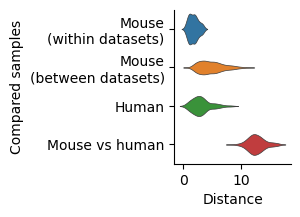

In [10]:
# Plot
fig,ax=plt.subplots(figsize=(1.5,2))
sb.violinplot(y=y_col,x='Distance',data=plot,inner=None,linewidth=0.5,ax=ax)
fig.set(facecolor = (0,0,0,0))
ax.set(facecolor = (0,0,0,0))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig(path_fig+f'batch_strength-pancreas_{ct}-violin.pdf',dpi=300,bbox_inches='tight')
plt.savefig(path_fig+f'batch_strength-pancreas_{ct}-violin.png',dpi=300,bbox_inches='tight')

In [11]:
# N comparisons (samples) per group
plot.groupby(y_col).size()

Compared samples
Human                         136
Mouse\n(between datasets)    1010
Mouse\n(within datasets)      166
Mouse vs human                833
dtype: int64

## Plot distance of between vs within comparisons
Number of standard deviations that between-system comparison distibution mean is away from within-system distibution (reference used to set mean and std), computed pre cell type separately for all within-system groups.

In [46]:
# Compute distance between within and between system comparison pairs
scores=[]
for dataset, dist in distances.items():
    for ct, dist_ct in dist.items():
        d_s0s1=dist_ct['s0s1']
        # This was before filtered so that groups with too many comparisons are not used - 
        # they have length of 0
        for d_type,d in {d_type:d for d_type,d in dist_ct.items() 
                         if d_type!='s0s1' and len(d)>0}.items():
            score=(d_s0s1.mean()-d.mean())/d.std()
            scores.append(dict(
                dataset=dataset,ct=ct,compared=d_type,score=score ))
scores=pd.DataFrame(scores)

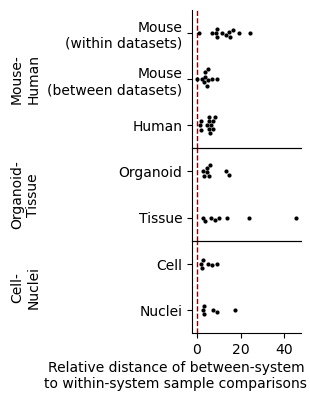

In [117]:
# Plot relative distances

# Use gridspec as different datasets have different number of categories
heights=[scores.query('dataset==@dataset').compared.nunique() for dataset in dataset_map]
nrows=len(heights)
fig = plt.figure(figsize=(1.4, 4.2))
fig.set(facecolor = (0,0,0,0))
gs = GridSpec(nrows, 1, height_ratios=heights)
# Set one ax as ref so that ax can be shared
ax0=None
for idx,(dataset,dataset_name) in enumerate(dataset_map.items()):
    ax = fig.add_subplot(gs[idx, 0], sharex=ax0)
    if ax0 is None:
        ax0=ax
    data_plot=scores.query('dataset==@dataset').copy()
    # Parse names of comparison groups
    compared_map={
        x: system_map[dataset][x.replace('s','').split('_')[0]
                              ]+(f'\n({x.split("_")[1]} datasets)' if '_' in x else '')
        for x in data_plot.compared.unique()}
    data_plot['compared_name']=data_plot.compared.map(compared_map)
    sb.swarmplot(x='score',y='compared_name',data=data_plot,ax=ax, c='k',s=3)
    ax.set_ylabel(dataset_name.replace('-','-\n'))
    ax.axvline(0,c='#8b0000',lw=1,linestyle='dashed')
    if idx==nrows-1:
        ax.set_xlabel('Relative distance of between-system\nto within-system sample comparisons')
        ax.xaxis.set_label_coords(-0.15, -0.3)
        plt.locator_params(axis='x', nbins=3)
    else:
        ax.xaxis.set_visible(False)
    ax.yaxis.set_label_coords(-1.4, 0.5)
    ax.set(facecolor = (0,0,0,0))
    ax.spines['right'].set_visible(False)
    if idx==0:
        ax.spines['top'].set_visible(False)
plt.subplots_adjust(hspace=0)
plt.savefig(path_fig+f'batch_strength-overview-swarm.pdf',dpi=300,bbox_inches='tight')
plt.savefig(path_fig+f'batch_strength-overview-swarm.png',dpi=300,bbox_inches='tight')